<a href="https://colab.research.google.com/github/pipuf/ml_dev_cert/blob/main/16_5_2_THEORY_Convolutional_Autoencoder_for_Compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrenar un autoencoder basado en capas Convolucionales en Mnist

In [ ]:
from skimage.transform import resize

import numpy as np
from keras.datasets import mnist


def resize_images(x,size):
  n=x.shape[0]
  h,w=size
  new_x=np.zeros((n,h,w,1))
  for i in range(n):
    new_x[i,:,:,0]=resize(x[i,:,:],size)
  return new_x

def load_data():
  size=32,32
  (x_train, _), (x_test, _) = mnist.load_data()
  print(f"Resizing training images to {size}...")
  x_train=resize_images(x_train,size)
  print(f"Resizing test images to {size}")
  x_test=resize_images(x_test,size)
  input_shape = x_train.shape[1:]
  return x_train,x_test,input_shape

x_train,x_test,input_shape = load_data()
print(x_train.shape,input_shape)


Resizing training images to (32, 32)...
Resizing test images to (32, 32)
(60000, 32, 32, 1) (32, 32, 1)


# Definición del modelo

Latent dim = 32 (encoded shape is (2, 2, 8))
Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 2, 2, 8)           6688      
_________________________________________________________________
decoder (Functional)         (None, 32, 32, 1)         7265      
Total params: 13,953
Trainable params: 13,953
Non-trainable params: 0
_________________________________________________________________
None
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_221 (Conv2D)          (None, 32, 32, 32)   

Text(0, 0.5, 'Validation error')

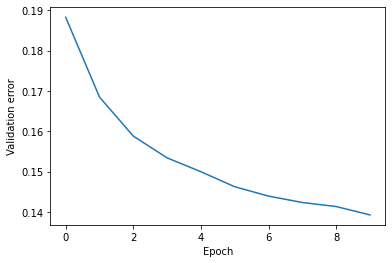

In [ ]:
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import MaxPooling2D,UpSampling2D

from keras.models import Model
import keras.backend as K

import matplotlib.pyplot as plt
from PIL import Image

# Salida determinística (comentar para aleatorizar el entrenamiento)
np.random.seed(1337)

# MNIST dataset


def ConvolutionalAutoencoder(input_shape,filters):

  def generate_encoder():
    encoder_input = Input(shape=input_shape, name='encoder_input')
    x = encoder_input
    x = Conv2D(filters*4, (3, 3), activation='relu', padding='same')(encoder_input)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(filters*2, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded_shape = K.int_shape(x)[1:]

    encoder = Model(encoder_input, x, name='encoder')
    return encoder, encoder_input, encoded_shape

  def generate_decoder(encoded_shape):
    latent_input = Input(shape=encoded_shape, name='decoder_input')

    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(latent_input)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(latent_input)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(filters*2, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(filters*4, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    decoder = Model(latent_input, x, name='decoder')
    return decoder, latent_input

  encoder, encoder_input, encoded_shape = generate_encoder()
  decoder, latent_input = generate_decoder(encoded_shape)
  autoencoder = Model(encoder_input, decoder(encoder(encoder_input)), name='autoencoder')
  return autoencoder, encoder, decoder, encoded_shape


filters=8
autoencoder, encoder, decoder, encoded_shape = ConvolutionalAutoencoder(input_shape,filters)
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

print(f"Latent dim = {np.prod(encoded_shape)} (encoded shape is {encoded_shape})")
print(autoencoder.summary())
print(encoder.summary())
print(decoder.summary())

batch_size = 128
# Train the autoencoder
history = autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=10,
                batch_size=batch_size)

import matplotlib.pyplot as plt

plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Validation error")


# Mostrar imágenes originales, y las obtenidas después de pasar por el modelo (luego de ser codificadas y decodificadas)

---



Original
Decoded


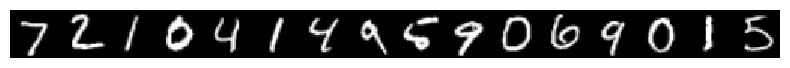

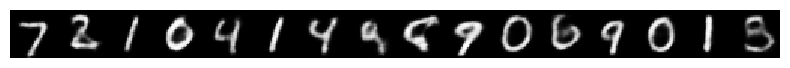

In [ ]:


# Predict the Autoencoder output from test images
x_decoded = autoencoder.predict(x_test)

def show_as_single_image(imgs):

  n,h,w,c=imgs.shape
  imgs = imgs.reshape((n, h,w))
  imgs = imgs.swapaxes(1,2).reshape((n*w, h)).swapaxes(0,1)
  imgs = (imgs * 255).astype(np.uint8)

  plt.figure(figsize=(1*8,n*8),dpi=100)
  plt.axis('off')
  plt.imshow(imgs, interpolation='none', cmap='gray')
  plt.tight_layout()

num=16
print("Original")
show_as_single_image(x_test[:num])
print("Decoded")
show_as_single_image(x_decoded[:num])


# Intentar generar nuevas muestras desde el espacio latente (no funciona, necesito usar [Autoencoders variacionales](https://blog.keras.io/building-autoencoders-in-keras.html) or GANs)

(16, 32, 32, 1)


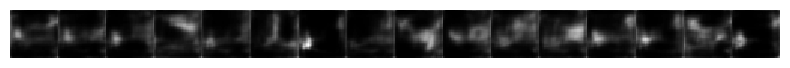

In [ ]:
num_images=16
random_latent_code = np.random.random_sample([num_images,*encoded_shape])

random_images = decoder.predict(random_latent_code)

print(random_images.shape)
show_as_single_image(random_images)
